In [1]:
import os
import glob
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import shutil
import random
%matplotlib inline

### configure your aws credentials to get writerights on S3

In [2]:
home = os.getcwd().split('AUT-CNN-TUB')[0]

# Image centering

In [3]:
def get_all_images_from_part(read_path, partname, extension):

    numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
    pats_path = [x.string for x in numbers if x is not None]

    if pats_path == []:
        print('ERROR: no directories in path or wrong naming')
        SystemExit
        
    if partname not in pats_path:
        if type(partname) is str:
            print("ERROR: directory for this partnumber doesn't exist" )
            SystemExit
        else:
            partname = str(partname)
            
            if partname not in pats_path:
                print("ERROR: directory for this partnumber doesn't exist")
                SystemExit
                
    if extension  not in ['gif', 'jpeg', 'jpg', 'png', 'JPG']:
        print('ERROR: unknown extension, ', extension)
        SystemExit
        
    else:
        data_path = os.path.join(os.path.join(read_path, partname), '*{}'.format(extension))
        files = glob.glob(data_path)
        return files

In [4]:
#read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry/')
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_canon/')
#read_path = '/home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/'

In [5]:
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
[x.string for x in numbers if x is not None]

['2',
 '13',
 '14',
 '1',
 '7.1',
 '8',
 '5',
 '4',
 '3',
 '10',
 '12',
 '11',
 '6',
 '7.2',
 '15',
 '9']

In [6]:
files = get_all_images_from_part(read_path, 1, 'JPG')# jpg, JPG

In [7]:
for z,i in enumerate(files):
    if '07.2.0.1.0421' in i:
        print(i, z)

In [8]:
file_path = files[9]
img_name = file_path.split('/')[-1]  
image = cv2.imread(file_path)

### original

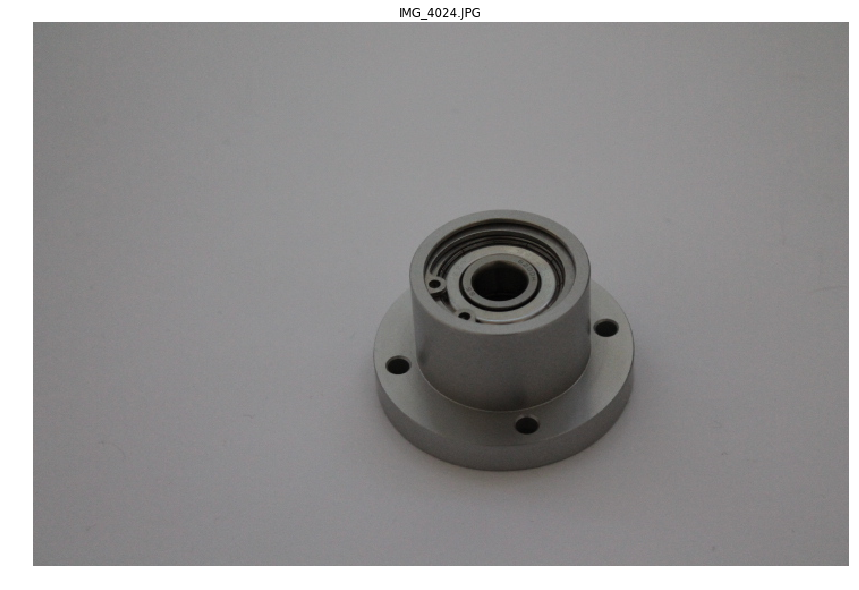

In [9]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### grayscale

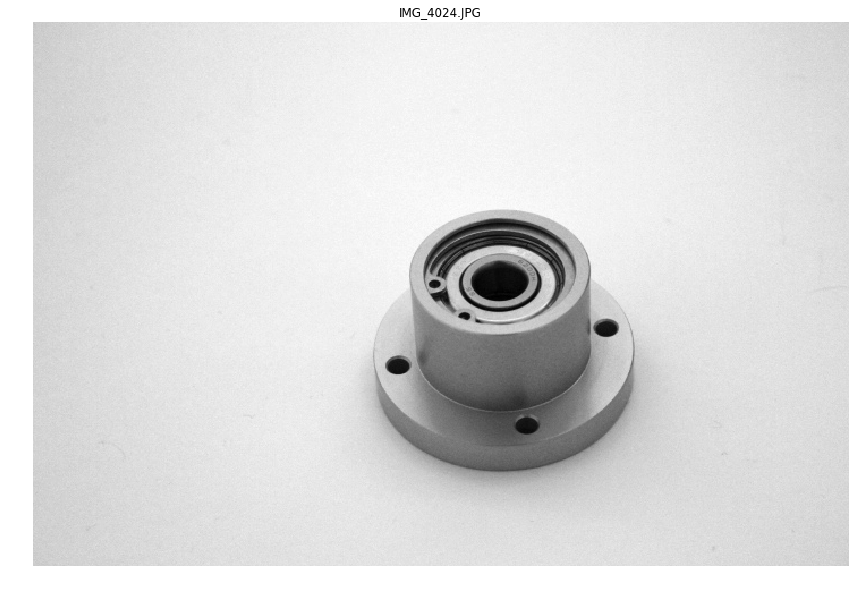

In [10]:
imgray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(imgray, cmap='gray');
plt.show()

In [11]:
form_factor = imgray.shape[1]/1280
brightness = imgray.mean()

In [12]:
imgray.max()

155

In [13]:
imgray.min()

2

In [14]:
imgray.mean()

131.06469328703704

In [15]:
imgray.var()

567.4812777415752

In [16]:
brightness

131.06469328703704

In [17]:
form_factor

0.5625

### blurred

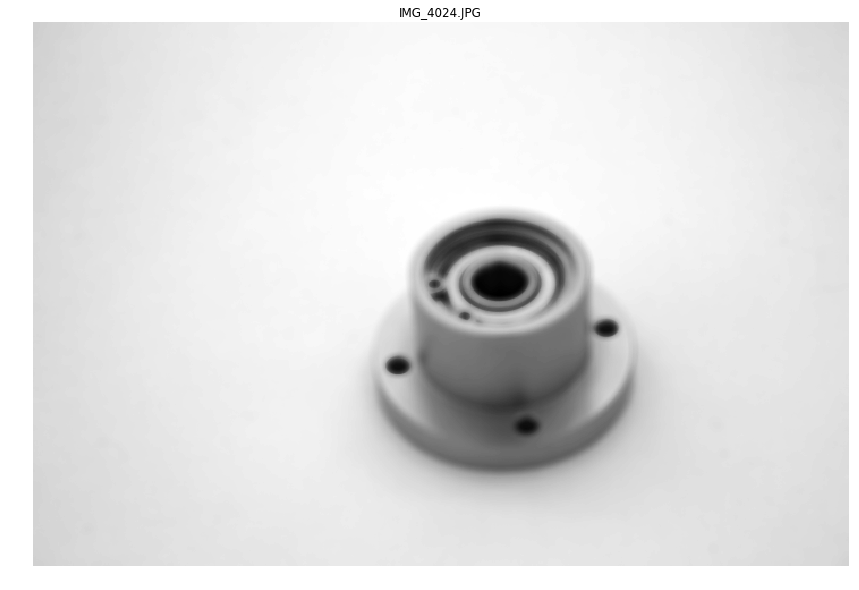

In [18]:
blurred = cv2.bilateralFilter(imgray,10, 50 / form_factor, 50 / form_factor)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(blurred,  cmap='gray')
plt.show()

In [19]:
10 / form_factor

17.77777777777778

In [20]:
brightness / form_factor

233.00389917695475

# edge detection

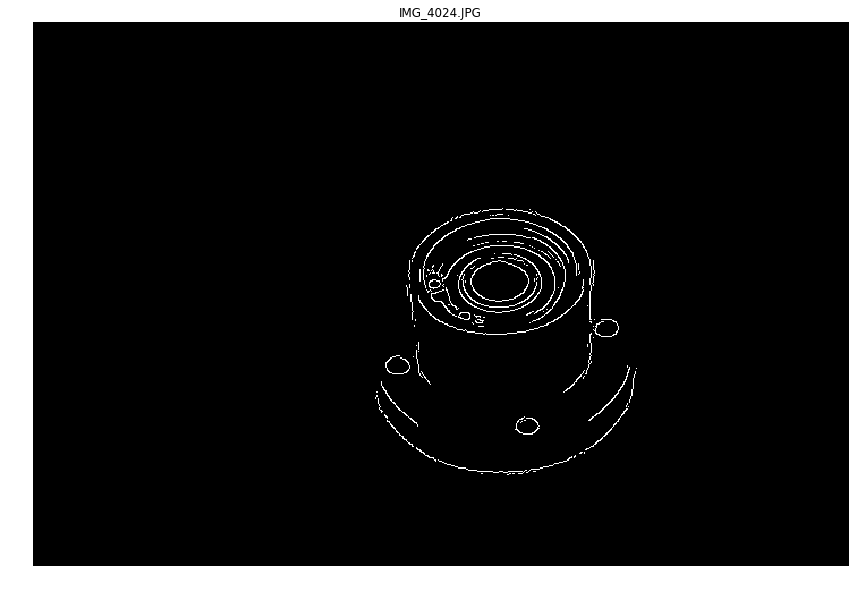

In [21]:
thresh = cv2.Canny(blurred, brightness/4 , brightness/4 )

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(thresh, cmap='gray');
plt.show()

# dilation

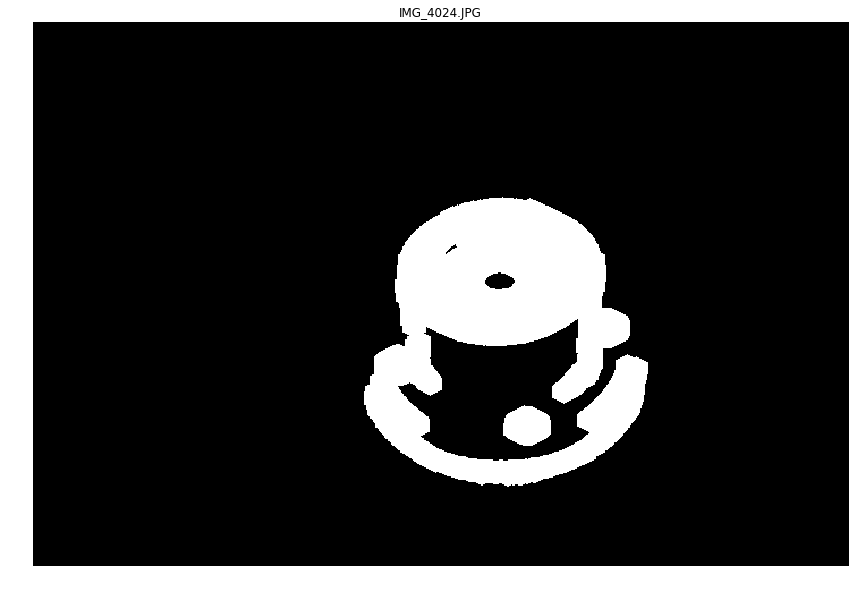

In [22]:
kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
dilation = cv2.dilate(thresh,kernel,iterations = 5)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(dilation, cmap='gray');
plt.show()

# get outer Contour

In [23]:
to_drop = []

_,contours,_ = cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

for e,c in enumerate(contours):
    for n,test in enumerate(contours):
        if n!= e:
            if c[:,:,0].max() < test[:,:,0].max():
                if c[:,:,0].min()  >  test[:,:,0].min():
                    if c[:,:,1].max() < test[:,:,1].max():
                        if c[:,:,1].min() > test[:,:,1].min():
                                to_drop.append(e)
if to_drop!= []:
    sub_con = np.delete(contours, to_drop).tolist()
else:
    sub_con = contours

In [24]:
len(contours)

4

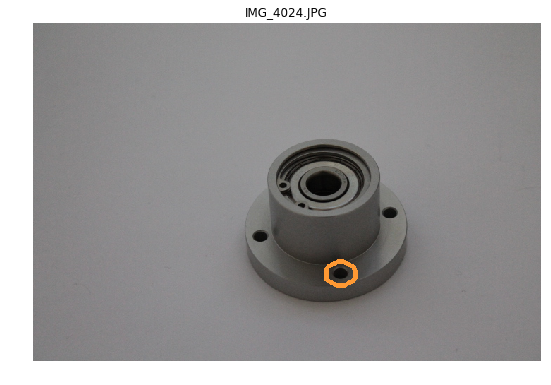

In [25]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(cv2.drawContours(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), contours, 0, (255, 153, 51), 5));
plt.show()

# get max contourArea

In [26]:
c = max(contours, key = cv2.contourArea)

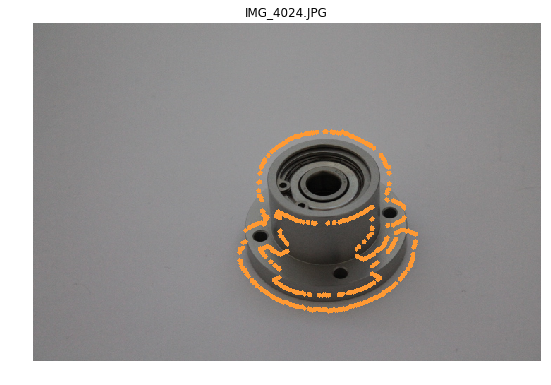

In [27]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(cv2.drawContours(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), c, -3, (255, 153, 51), 5));
plt.show()

### fit in circle, to know where to cut

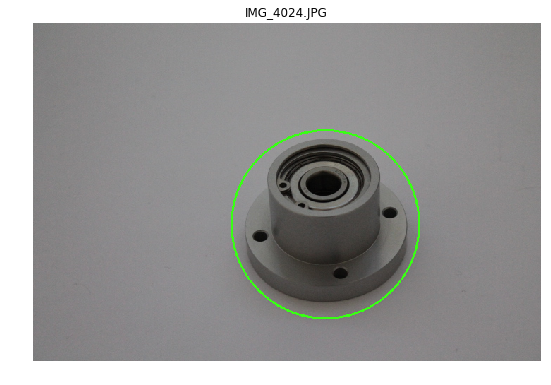

In [28]:
(x,y),radius = cv2.minEnclosingCircle(c)
center = (int(x),int(y))
radius = int(radius)
img = cv2.circle(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
                 center,
                 radius,
                 (57, 255,20),2)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(img)
plt.show()

# cutted and scaled image

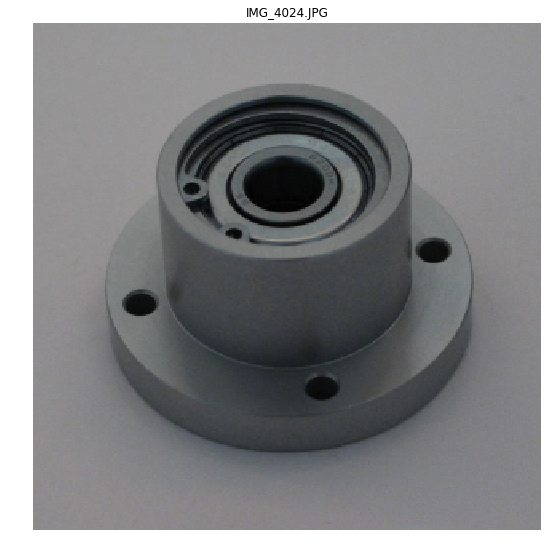

In [29]:
scale = 1.2
scaled_rad = int(radius * scale)
try:
    img_cutted = image[center[1] - scaled_rad : center[1] + scaled_rad,
                       center[0] - scaled_rad : center[0] + scaled_rad,
                       : ] 
except:
    img_cutted = image[center[1] - radius : center[1] + radius,
                       center[0] - radius : center[0] + radius,
                       : ] 
    
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(img_cutted)
plt.show()

In [30]:
img_cutted.var()

1439.4397119022797

In [31]:
def get_part_from_image(image, scale = 1.1):
    
    imgray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    brightness = imgray.mean()
    blurred = cv2.bilateralFilter(imgray, 10, brightness / form_factor, brightness / form_factor)
    thresh = cv2.Canny(blurred, brightness / 4 , brightness / 4 )
    
    kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilation = cv2.dilate(thresh,kernel,iterations = 5)
    
    _,contours,_ = cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    c = max(contours, key = cv2.contourArea)

    (x,y),radius = cv2.minEnclosingCircle(c)
    center = (int(x),int(y))
    radius = int(radius)

    scaled_rad = int(radius * scale)
    try:
        img_cutted = image[center[1] - scaled_rad : center[1] + scaled_rad,
                           center[0] - scaled_rad : center[0] + scaled_rad,
                           : ] 
    except:
        img_cutted = image[center[1] - radius : center[1] + radius,
                           center[0] - radius : center[0] + radius,
                           : ] 

    return img_cutted


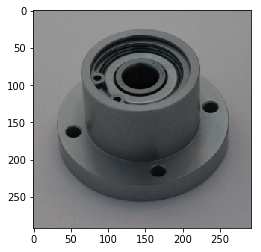

In [32]:
plt.imshow(get_part_from_image(image, scale = 1.1))
plt.show()

0 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_4011.JPG
1305.303185202876


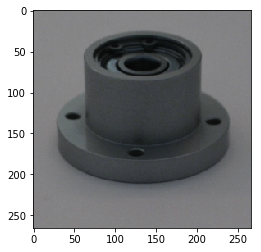

1 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3556.JPG
1394.1555484821456


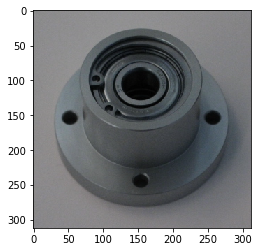

2 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3527.JPG
1372.9325900265153


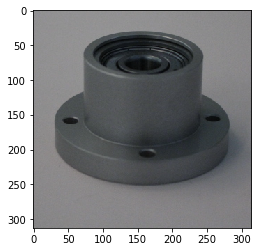

3 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3595.JPG
1742.6997525274612


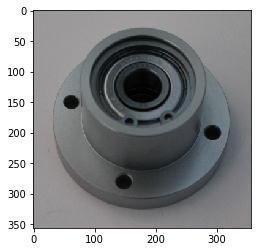

4 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3962.JPG
1458.2942469591437


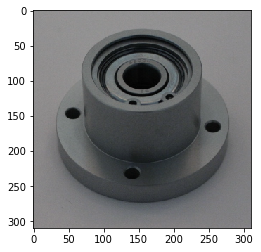

5 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3996.JPG
1203.0114171566652


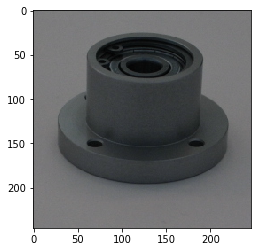

6 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_4040.JPG
1371.1241553974505


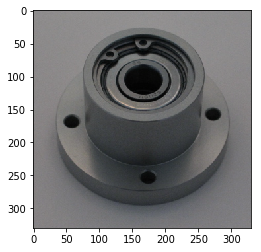

7 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_4006.JPG
1223.2027295454413


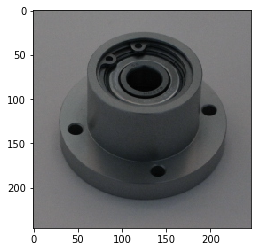

8 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3956.JPG
1434.414530602779


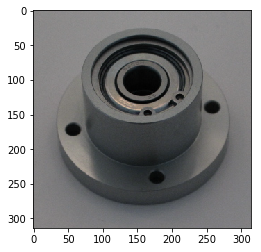

9 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_4024.JPG
1523.2745288840154


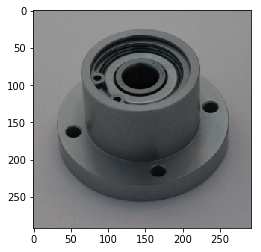

In [33]:
files = get_all_images_from_part(read_path, 1, 'JPG') #jpg
for i, file_path in enumerate(files[:10]):
    image = cv2.imread(file_path)
    print(i,file_path)
    try:
        plt.imshow(get_part_from_image(image, scale = 1.1))
        print(get_part_from_image(image, scale = 1.1).var())
        plt.show()
    except:
        print('ERROR: ', file_path)

## genrate folder whith cerndered and well shaped images

In [35]:

new_size = int(28 * 4)
for camera in ['industry', 'canon' ]:

    home = os.getcwd().split('AUT-CNN-TUB')[0]
    read_path = os.path.join(home,'AUT-CNN-TUB/Data/Raw_Data_27072018_{}/'.format(camera))
    write_path = os.path.join(home,
                              'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_{}x{}/'.format(camera,
                                                                                             new_size,
                                                                                             new_size))

    extension = 'jpg'
    form_factor = imgray.shape[1]/1280

    numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])

    for part_nr in [x.string for x in numbers if x is not None]:
        for file_path in get_all_images_from_part(read_path, part_nr, extension):
            img_name = file_path.split('/')[-1].replace('.jpg','')
            image = cv2.imread(file_path)

            img_centerd = get_part_from_image(image)
            if img_centerd is not None:
                try:
                    img_resized = cv2.resize(img_centerd,(new_size, new_size))
                except:
                    print('Image {}.jpg is to small.'.format(img_name))
                    img_resized = None

                part_patch =os.path.join(write_path, part_nr)

                if img_resized is not None:
                    if img_resized.var() > 500 * form_factor:
                        if os.path.exists(part_patch):
                            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
                        else:
                            os.makedirs(part_patch)
                            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
                    else:
                        print('Image {}.jpg does not have the necessary variance.'.format(img_name))


Image 02.0.0.0.0009.jpg is to small.
Image 02.0.0.0.0008.jpg is to small.
Image 02.0.0.1.0286.jpg does not have the necessary variance.
Image 02.0.0.1.0285.jpg does not have the necessary variance.
Image 13.0.0.1.0230.jpg is to small.
Image 13.0.0.1.0235.jpg is to small.
Image 13.0.0.1.0227.jpg is to small.
Image 13.0.0.1.0225.jpg is to small.
Image 13.0.0.1.0232.jpg is to small.
Image 13.0.0.1.0234.jpg is to small.
Image 13.0.0.1.0216.jpg is to small.
Image 13.0.0.1.0233.jpg is to small.
Image 13.0.0.1.0229.jpg is to small.
Image 13.0.0.1.0236.jpg is to small.
Image 13.0.0.1.0217.jpg is to small.
Image 13.0.0.1.0222.jpg is to small.
Image 13.0.0.1.0205.jpg is to small.
Image 13.0.0.1.0218.jpg is to small.
Image 13.0.0.1.0226.jpg is to small.
Image 13.0.0.1.0206.jpg is to small.
Image 07.1.0.1.0300.jpg is to small.
Image 07.1.0.1.0302.jpg is to small.
Image 07.1.0.1.0301.jpg is to small.
Image 07.1.0.1.0303.jpg is to small.
Image 07.1.0.1.0294.jpg is to small.
Image 08.0.0.2.0446.jpg d

### downscale

In [37]:
new_size = int(28 * 1)
for camera in ['industry', 'canon' ]:

    home = os.getcwd().split('AUT-CNN-TUB')[0]
    read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_112x112/'.format(camera))
    write_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_{}x{}/'.format(camera, new_size, new_size))

    extension = 'jpg'

    numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
    for part_nr in [x.string for x in numbers if x is not None]:
        for file_path in get_all_images_from_part(read_path, part_nr, extension):
            img_name = file_path.split('/')[-1].replace('.jpg','')
            image = cv2.imread(file_path)

            try:
                img_resized = cv2.resize(image,(new_size, new_size))
            except:
                print('Image {}.jpg is to small.'.format(img_name))

            part_patch =os.path.join(write_path, part_nr)

            if os.path.exists(part_patch):
                cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
            else:
                os.makedirs(part_patch)
                cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)

In [ ]:
new_size = 50

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_200x200/'.format(camera))
write_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_{}x{}/'.format(camera, new_size, new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].replace('.jpg','')
        image = cv2.imread(file_path)

        try:
            img_resized = cv2.resize(image,(new_size, new_size))
        except:
            print('Image {}.jpg is to small.'.format(img_name))
        
        part_patch =os.path.join(write_path, part_nr)
            
        if os.path.exists(part_patch):
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
        else:
            os.makedirs(part_patch)
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)

In [234]:
new_size = 28

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_200x200/'.format(camera))
write_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_{}x{}/'.format(camera, new_size, new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].replace('.jpg','')
        image = cv2.imread(file_path)

        try:
            img_resized = cv2.resize(image,(new_size, new_size))
        except:
            print('Image {}.jpg is to small.'.format(img_name))
        
        part_patch =os.path.join(write_path, part_nr)
            
        if os.path.exists(part_patch):
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
        else:
            os.makedirs(part_patch)
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)

### summarize

In [175]:
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_200x200/'.format(camera))
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
print('Images in File:')
for part_nr in [x.string for x in numbers if x is not None]:
    print('{}\t{}'.format(len(os.listdir(os.path.join(read_path, part_nr))), part_nr))


Images in File:
1060	2
1029	13
1022	14
1160	1
1074	7.1
1271	8
1231	5
970	4
1072	3
1047	10
999	12
1149	11
773	6
916	7.2
1052	15
945	9


In [176]:
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}/'.format(camera))
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
print('Images in File:')
for part_nr in [x.string for x in numbers if x is not None]:
    print('{}\t{}'.format(len(os.listdir(os.path.join(read_path, part_nr))), part_nr))


Images in File:
1097	2
1075	13
1117	14
1160	1
1079	7.1
1272	8
1234	5
970	4
1072	3
1047	10
1150	12
1161	11
832	6
1257	7.2
1059	15
948	9


In [330]:
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}/'.format(camera))
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])

read_path1 = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_200x200_alt/'.format(camera))
print('Images in File:')
for part_nr in [x.string for x in numbers if x is not None]:
    print('{}\t{}'.format(((len(os.listdir(os.path.join(read_path, part_nr)))-len(os.listdir(os.path.join(read_path1, part_nr))))/len(os.listdir(os.path.join(read_path, part_nr)))), part_nr))


Images in File:
0.03372835004557885	2
0.04279069767441861	13
0.08504923903312445	14
0.0	1
0.004633920296570899	7.1
0.0007861635220125787	8
0.0024311183144246355	5
0.0	4
0.0	3
0.0	10
0.13130434782608696	12
0.0103359173126615	11
0.07091346153846154	6
0.27128082736674625	7.2
0.0066100094428706326	15
0.0031645569620253164	9


In [366]:
imgray.var()

567.4812777415752

In [367]:
imgray.shape

(480, 720)

In [371]:
cv2.resize(imgray,(int(480/10), int(720/10))).var()


560.748794367284

In [364]:
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}/'.format(camera))
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])

read_path1 = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_200x200/'.format(camera))
print('Images in File:')
for part_nr in [x.string for x in numbers if x is not None]:
    print('{}\t{}'.format(((len(os.listdir(os.path.join(read_path, part_nr)))-len(os.listdir(os.path.join(read_path1, part_nr))))/len(os.listdir(os.path.join(read_path, part_nr)))), part_nr))


Images in File:
0.005319148936170213	2
0.0	13
0.10112359550561797	14
0.049019607843137254	1
0.03546099290780142	7.1
0.0	8
0.06504065040650407	5
0.025	4
0.016129032258064516	3
0.0	10
0.0	12
0.0	11
0.19718309859154928	6
0.008130081300813009	7.2
0.0	15
0.013333333333333334	9


In [49]:
size =  int(28 *2)
read_path = os.path.join(home,'/home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_merge_aug/centered_{}x{}'.format(size, size))
path_length   = len(read_path) 

test_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}x{}/test/'.format(size, size))
validate_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}x{}/validate/'.format(size, size))
train_path = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}x{}/train/'.format(size, size))

ratio = 0.7 #train
# test = 0.2
# validate = 0.1
img_path = read_path
GRBtoGray = False
extension = 'jpg'


numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    
    files = get_all_images_from_part(read_path, part_nr, extension)            
    num_imag = len(files)
    Data = np.arange(0, num_imag)            
    random.shuffle(Data)  
    DataTrain = Data[:int(np.round(ratio * num_imag))]              
    DataTest = Data[int(np.round(ratio * num_imag)) : int(np.round(0.9 * num_imag))]         
    DataVal  = Data[int(np.round(0.9 * num_imag)) : ]         
    
    if os.path.exists(test_path) is False:
        os.makedirs(test_path)
        
    if os.path.exists(validate_path) is False:
        os.makedirs(validate_path)
        
    if os.path.exists(train_path) is False:
        os.makedirs(train_path)
    
    for i,f1 in enumerate(files):
        img_name = f1.split('/')[-1]        

        img = cv2.imread(f1)
        if(GRBtoGray == True):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      


        if(i in DataTrain):
            cv2.imwrite(train_path + img_name, img)  
        if(i in DataTest):
            cv2.imwrite(test_path + img_name, img) 
        if(i in DataVal):
            cv2.imwrite(validate_path + img_name, img)  

### save zip on S3

In [50]:
import boto3
import botocore

s3 = boto3.resource('s3')
bucket = s3.Bucket('imagesforcnn')

for bucket in s3.buckets.all():
    print(bucket.name)
        
for object in s3.Bucket('imagesforcnn').objects.all():
    print(object)

imagesforcnn
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/')
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/CNN_rgb.py')
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/CNN_rgb_merge.py')
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/CNN_rgb_merge_200.py')
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/layers.py')
s3.ObjectSummary(bucket_name='imagesforcnn', key='OLD/')
s3.ObjectSummary(bucket_name='imagesforcnn', key='OLD/Centered.zip')
s3.ObjectSummary(bucket_name='imagesforcnn', key='OLD/Datensatz.zip')
s3.ObjectSummary(bucket_name='imagesforcnn', key='OLD/TF_Images_28.tar.xz')
s3.ObjectSummary(bucket_name='imagesforcnn', key='models/')
s3.ObjectSummary(bucket_name='imagesforcnn', key='models/model_merge_28_b1000_s50_2018-09-05_17-49.zip')
s3.ObjectSummary(bucket_name='imagesforcnn', key='models/model_merge_28_b100_s10000_2018-09-05_19-13.zip')
s3.ObjectSummary(bucket_name='imagesforcnn', key='models/model_merge_28_b100_s500_2018-09-05_17-56.zip'

In [48]:
# zip dir 
size =  int(28)

from_dir = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}x{}'.format(size, size))
to_dir = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}x{}'.format(size, size))

shutil.make_archive(to_dir,
                    'zip',
                    from_dir
                    )

'/home/jeronimo/git/AUT-CNN-TUB/Data/TF_Images_final_28x28.zip'

In [ ]:

path = os.path.join(home,'AUT-CNN-TUB/Data/')

from_dir = os.path.join(home,'AUT-CNN-TUB/Data/Centered')
to_dir = os.path.join(home,'AUT-CNN-TUB/Data/')
filename = 'Centered'

extension = 'zip'

if extension is 'zip':
    shutil.make_archive(os.path.join(os.path.join(to_dir, filename)), extension, from_dir)

# Upload a new file
data = open(os.path.join(to_dir, filename + '.{}'.format(extension)), 'rb')
print('uploading {}.{} ... '.format(filename, extension), end='\r')
bucket.put_object(Key=filename + '.{}'.format(extension), Body=data)
print('uploading {}.{} finished'.format(filename, extension))


In [70]:
for test in range(100,920+1, 100):
    print(test)

100
200
300
400
500
600
700
800
900


In [76]:
im_num = 4303

In [78]:
val_counter = 0
while val_counter <  im_num//400:
    val_counter += 1
    print(val_counter)    

1
2
3
4
5
6
7
8
9
10


In [75]:
im_num//100

40

In [81]:
im_num%400/400

0.7575